----------------------------------------------------------------------
    PokéFind - Détection de Pokémon sur cartes à collectionner
----------------------------------------------------------------------

 Étape 1: Chargement de la collection de cartes
----------------------------------------------------------------------
Utilisation de SIFT
  carte_fourbelin1.jpg: 3000 keypoints
  carte_fourbelin2.jpg: 3000 keypoints
  carte_fourbelin3.jpg: 3000 keypoints
  carte_fourbelin4.jpg: 3000 keypoints
  carte_fourbelin5.jpg: 3000 keypoints
  carte_hoothoot1.jpg: 3000 keypoints
  carte_hoothoot2.jpg: 3000 keypoints
  carte_hoothoot3.jpg: 3001 keypoints
  carte_hoothoot4.jpg: 3000 keypoints
  carte_hoothoot5.jpg: 3001 keypoints
  carte_kungfouine.jpeg: 3000 keypoints
  carte_kungfouine1.jpg: 3000 keypoints
  carte_kungfouine2.jpg: 3000 keypoints
  carte_kungfouine3.jpg: 3000 keypoints
  carte_kungfouine4.jpg: 3000 keypoints
  carte_kungfouine5.jpg: 3000 keypoints
  carte_pandespiegle.jpeg: 300

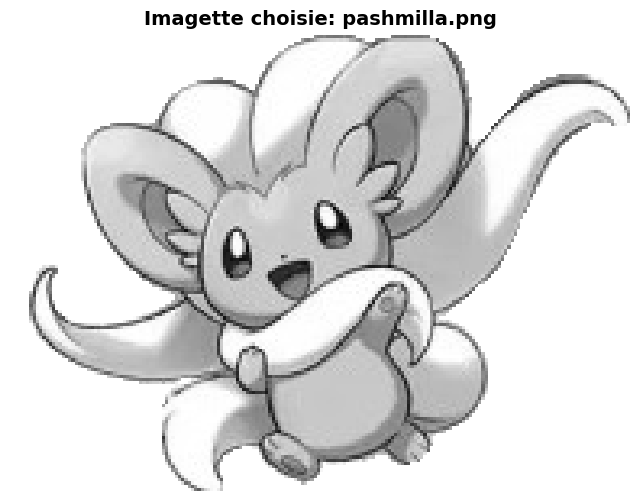


 Étape 3: Extraction des features de l'imagette
----------------------------------------------------------------------

 Imagette: 117 keypoints détectés

 Étape 4: Recherche dans la collection
----------------------------------------------------------------------

TOP 5 des correspondances:
  1. carte_pashmilla2.jpg           Matches: 19
  2. carte_pashmilla1.jpg           Matches: 17
  3. carte_pashmilla3.jpg           Matches: 16
  4. carte_pashmilla5.jpg           Matches: 12
  5. carte_pashmilla4.jpg           Matches: 9

 Étape 5: Affichage du résultat
----------------------------------------------------------------------

POKÉMON RECONNU: carte_pashmilla2.jpg
Nombre de matches: 19
Confiance: Faible


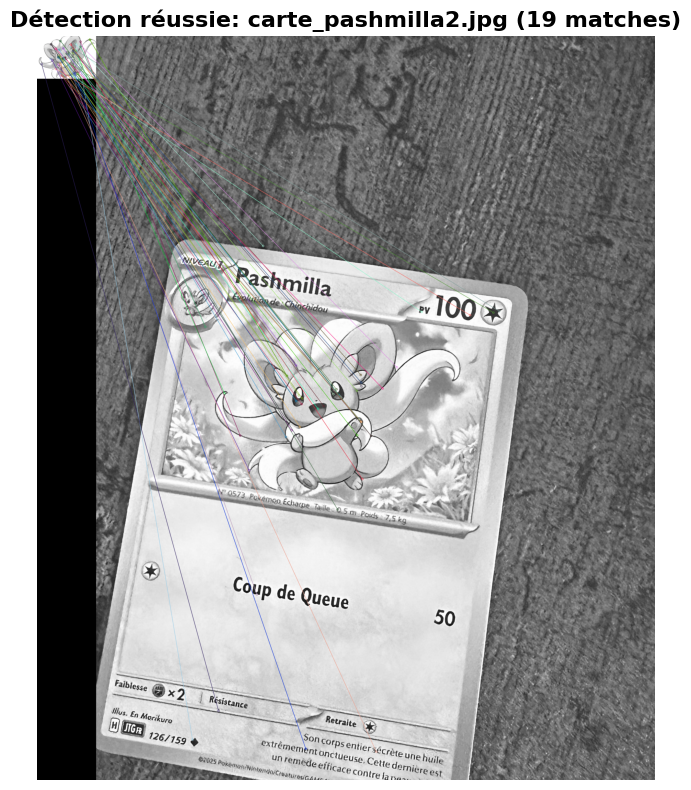

Visualisation affichée

 Merci d'avoir utilisé PokéFind!


In [ ]:


import cv2
import os #Fonctions pour manipuler les dossier et fichier (fait partie de python pas besoin d'installer quoi que ce soit)
import numpy as np
import matplotlib.pyplot as plt



# CONFIGURATION



DOSSIER_IMAGETTES = "data/imagette"  
DOSSIER_CARTES = "data/carte"        

# Paramètres de détection
CROP_RATIO_CARTE = 0.6    # Ratio de crop pour les cartes (0.6 = 60% du centre)
CROP_RATIO_IMAGETTE = 1.0 
NOMBRE_FEATURES = 6000    # Nombre maximum de keypoints à détecter
RATIO_TEST = 0.75         # Seuil du ratio test de Lowe 
SEUIL_MATCHES = 15        # Nombre minimum de matches pour valider une détection

# Choix de l'algorithme
UTILISER_SIFT = True  # True = SIFT , False = ORB 



# FONCTIONS UTILITAIRES


def afficher_image(image, titre="Image"):
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap='gray')
    plt.title(titre, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()


def crop_centre(image, crop_ratio=0.6):
    hauteur, largeur = image.shape
    
    # Calcul des nouvelles dimensions
    nouvelle_hauteur = int(hauteur * crop_ratio)
    nouvelle_largeur = int(largeur * crop_ratio)
    
    # Calcul du point de départ pour centrer le crop
    debut_x = (largeur - nouvelle_largeur) // 2
    debut_y = (hauteur - nouvelle_hauteur) // 2
    
    # Découpage
    return image[debut_y:debut_y + nouvelle_hauteur, debut_x:debut_x + nouvelle_largeur]



# CHARGEMENT ET PRÉPARATION DES DONNÉES


def charger_collection_cartes(dossier_cartes):
  
    collection = []
    
    # Initialisation du détecteur
    if UTILISER_SIFT:
        print("Utilisation de SIFT")
        detecteur = cv2.SIFT_create(nfeatures=NOMBRE_FEATURES)
    else:
        print("Utilisation de ORB")
        detecteur = cv2.ORB_create(nfeatures=NOMBRE_FEATURES, scaleFactor=1.2, nlevels=8)
    
    # Parcours de tous les fichiers du dossier
    fichiers = os.listdir(dossier_cartes)
    
    for nom_fichier in fichiers:
        chemin_complet = os.path.join(dossier_cartes, nom_fichier)
        
        #image en niveaux de gris
        image = cv2.imread(chemin_complet, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            continue  # fichier non valide
        
        # Crop de la carte pour garder uniquement la zone centrale (où est le Pokémon)
        image_croppee = crop_centre(image, crop_ratio=CROP_RATIO_CARTE)
        
        # Extraction des keypoints et descripteurs
        keypoints, descripteurs = detecteur.detectAndCompute(image_croppee, None)
        
        # On garde seulement si des descripteurs ont été trouvés
        if descripteurs is not None:
            collection.append({
                "filename": nom_fichier,
                "image": image_croppee,
                "keypoints": keypoints,
                "descriptors": descripteurs
            })
            print(f"  {nom_fichier}: {len(keypoints)} keypoints")
    
    print(f"\n{len(collection)} cartes chargées")
    return collection


def charger_imagette(dossier_imagettes):
    extensions_valides = ('.png', '.jpg', '.jpeg')
    imagettes = [f for f in os.listdir(dossier_imagettes) 
                 if f.lower().endswith(extensions_valides)]
    
    if not imagettes:
        raise ValueError(f"Aucune imagette trouvée dans {dossier_imagettes}")
    
    # Menu de sélection
    print("\nChoisissez le pokemon:")
    for i, nom_fichier in enumerate(imagettes, 1):
        print(f"{i}. {nom_fichier}")
    
    # Saisie utilisateur
    while True:
        choix = input(f"\nEntrez le numéro (1-{len(imagettes)}): ")
        if choix.isdigit() and 1 <= int(choix) <= len(imagettes):
            index_choisi = int(choix) - 1
            break
        print("Entrée invalide, réessayez.")
    
    # Chargement de l'imagette choisie
    nom_imagette = imagettes[index_choisi]
    chemin_imagette = os.path.join(dossier_imagettes, nom_imagette)
    print(f"\n Vous avez choisi: {nom_imagette}")
    
    # Chargement avec gestion du canal alpha (transparence car png la plupart du temps)
    imagette = cv2.imread(chemin_imagette, cv2.IMREAD_UNCHANGED)
    
    if imagette is None:
        raise FileNotFoundError(f"Impossible de charger: {chemin_imagette}")
    
    # Traitement selon le type d'image
    if len(imagette.shape) == 3 and imagette.shape[2] == 4:
        # PNG avec transparence (canal alpha)
        alpha = imagette[:, :, 3]  # Canal de transparence
        
        # Conversion BGR vers niveaux de gris
        imagette = cv2.cvtColor(imagette[:, :, :3], cv2.COLOR_BGR2GRAY)
        
        # Remplacement du fond transparent par du blanc (au lieu de noir)
        # Améliore la détection en évitant les faux keypoints sur le fond
        imagette[alpha == 0] = 255
    
    elif len(imagette.shape) == 3:
        # image couleur normale (sans transparence)
        imagette = cv2.cvtColor(imagette, cv2.COLOR_BGR2GRAY)
    
    
    imagette = crop_centre(imagette, crop_ratio=CROP_RATIO_IMAGETTE)
    
  
    afficher_image(imagette, f"Imagette choisie: {nom_imagette}")
    
    return imagette


def extraire_features_imagette(imagette):
  
    if UTILISER_SIFT:
        detecteur = cv2.SIFT_create(nfeatures=NOMBRE_FEATURES)
    else:
        detecteur = cv2.ORB_create(nfeatures=NOMBRE_FEATURES, scaleFactor=1.2, nlevels=8)
    
    
    keypoints, descripteurs = detecteur.detectAndCompute(imagette, None)
    
    print(f"\n Imagette: {len(keypoints)} keypoints détectés")
    
    return keypoints, descripteurs




def trouver_meilleure_correspondance(descripteurs_imagette, collection):
    # initialisation du matcher
    if UTILISER_SIFT:
        # FLANN matcher pour SIFT
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
    else:
        # Brute Force matcher pour ORB
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    
    meilleure_carte = None
    meilleur_score = 0
    tous_resultats = []
    
    # comparaison avec chaque carte
    for carte in collection:
        
        matches = matcher.knnMatch(descripteurs_imagette, carte["descriptors"], k=2)
        
        # Ratio test de Lowe
        good_matches = []
        for match_pair in matches:
            if len(match_pair) == 2:
                meilleur_match, deuxieme_match = match_pair
                if meilleur_match.distance < RATIO_TEST * deuxieme_match.distance:
                    good_matches.append(meilleur_match)
        
        # calcul du score (nombre de bons matches)
        score = len(good_matches)
        
        # Sauvegarde pour affichage debug
        tous_resultats.append({
            'filename': carte['filename'],
            'score': score,
            'matches': len(good_matches)
        })
        
        
        if score > meilleur_score:
            meilleur_score = score
            meilleure_carte = carte
    
    #(debug)
    tous_resultats.sort(key=lambda x: x['score'], reverse=True)
    print("\nTOP 5 des correspondances:")
    for i, resultat in enumerate(tous_resultats[:5], 1):
        print(f"  {i}. {resultat['filename']:<30} Matches: {resultat['matches']}")
    
    return meilleure_carte, meilleur_score


def afficher_resultat(imagette, keypoints_imagette, descripteurs_imagette, carte, score):
    
    if score < SEUIL_MATCHES:
        print(f"\nAucune reconnaissance fiable")
        print(f"   Meilleur score: {score} matches (seuil: {SEUIL_MATCHES})")
        return
    
    
    print(f"\n{'='*70}")
    print(f"POKÉMON RECONNU: {carte['filename']}")
    print(f"{'='*70}")
    print(f"Nombre de matches: {int(score)}")
    print(f"Confiance: {'Élevée' if score > 80 else 'Moyenne' if score > 40 else 'Faible'}")
    

    
    # Matcher pour la visualisation
    if UTILISER_SIFT:
        matcher = cv2.BFMatcher(cv2.NORM_L2)
    else:
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    
    matches = matcher.match(descripteurs_imagette, carte["descriptors"])
    matches = sorted(matches, key=lambda x: x.distance)
    matches_a_afficher = matches[:50]
    
    # creation de l'image 
    image_resultat = cv2.drawMatches(
        imagette, keypoints_imagette,
        carte["image"], carte["keypoints"],
        matches_a_afficher, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    # affichage avec matplotlib
    plt.figure(figsize=(16, 8))
    plt.imshow(image_resultat, cmap='gray')
    plt.title(f"Détection réussie: {carte['filename']} ({int(score)} matches)", 
              fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("Visualisation affichée")






def main():
  
  
 
    print("-"*70)
    print("    PokéFind - Détection de Pokémon sur cartes à collectionner")
    print("-"*70)
    print()
    
    try:
        # Étape 1: Chargement de la collection de cartes
        print(" Étape 1: Chargement de la collection de cartes")
        print("-" * 70)
        collection_cartes = charger_collection_cartes(DOSSIER_CARTES)
        
        if not collection_cartes:
            print(" Aucune carte valide trouvée dans le dossier")
            return
        
        # Étape 2: Choix et chargement de l'imagette
        print("\n Étape 2: Choix de l'imagette à rechercher")
        print("-" * 70)
        imagette = charger_imagette(DOSSIER_IMAGETTES)
        
        # Étape 3: Extraction des features de l'imagette
        print("\n Étape 3: Extraction des features de l'imagette")
        print("-" * 70)
        keypoints_imagette, descripteurs_imagette = extraire_features_imagette(imagette)
        
        if descripteurs_imagette is None:
            print(" Aucun keypoint détecté dans l'imagette")
            return
        
        # Étape 4: Recherche de la meilleure correspondance
        print("\n Étape 4: Recherche dans la collection")
        print("-" * 70)
        meilleure_carte, score = trouver_meilleure_correspondance(
            descripteurs_imagette, 
            collection_cartes
        )
        
        # Étape 5: Affichage du résultat
        print("\n Étape 5: Affichage du résultat")
        print("-" * 70)
        afficher_resultat(imagette, keypoints_imagette, descripteurs_imagette, meilleure_carte, score)
        
        print("\n" + "="*70)
        print(" Merci d'avoir utilisé PokéFind!")
        print("="*70)
        
    except FileNotFoundError as e:
        print(f"\n Erreur: {e}")
        print("Vérifiez que les dossiers et fichiers existent.")
    
    except Exception as e:
        print(f"\n Erreur inattendue: {e}")
        import traceback
        traceback.print_exc()


# Point d'entrée du programme
if __name__ == "__main__":
    main()